# Descriptive (Spatial) Analytics

Analyze taxi demand patterns for the relevant one-year period and 
city (please check carefully which year your team has been allocated). 

Specifically show how these
patterns (start time, trip length, start and end location, Idle Time Minutes, average idle time between trips, and so 
on) for the given sample varies in different spatio-temporal resolution (i.e., census tract vs. varying
hexagon diameter and/or temporal bin sizes). 

Give possible reasons for the observed patterns.

## 1.1 Average idle time

To account for large time gaps when the driver does not work, we introduce a threshold of xx to consider only significant idle periods. In the following we present the steps we followed to calculate the average idle time:

1. **Sorting the Trips in ascending order for each taxi:** We sort the trips in ascending order for each taxi and start time.

2. **Identifying the Idle Periods:** For each driver, we find the time gap between the end time of one trip and the start time of the next trip. 

3. **Introducing a threshold of xx hours:** If the time gap exceeds the defined threshold of xx minutes (i.e., xx hours), we can ignore this time gaps, because the driver is not working at that time. By introducing a threshold, you can exclude the large time gaps when the driver does not work from the calculation of the average idle time. This approach provides a more accurate representation of the idle time during active working periods.

4. **Summing Idle Times up:** We add up all the significant idle times calculated after step 3 for all drivers to get the total idle time.

5. **Counting the Idle Periods:** We count the number of significant idle periods observed in step 2. This will be the total number of significant idle periods for all drivers.

6. **Calculating the Average:** We divide the total idle time by the number of significant idle periods to find the average idle time per significant idle period.


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime
import numpy as np

import descriptive as desc

In [2]:
# import datasets
df_chicago = pd.read_csv("data\datasets\df_chicago.csv.zip")
# dfChicago_hourly = pd.read_csv("data\datasets\df_chicago_hourly.csv")

In [3]:
df_chicago["Trip_Minutes"] = np.floor(df_chicago["Trip_Seconds"] / 60)
df_chicago["Pickup_C->Dropoff_C"] = df_chicago["Pickup_Census_Tract"].astype(str)+"->"+df_chicago["Dropoff_Census_Tract"].astype(str)

In [4]:
palette = "turbo"

In [5]:
# Sort trip data by start time
df = df_chicago.sort_values(by=['Taxi_ID', 'Original_Trip_Start_Timestamp'])

# Reset index
df.reset_index(drop=True, inplace=True)

# defining a threshold in minutes
threshold_minutes = 480

# Calculate time differences using vectorized operations
time_diff = (
    pd.to_datetime(df["Original_Trip_Start_Timestamp"]) -
    pd.to_datetime(df["Original_Trip_End_Timestamp"].shift())
).dt.total_seconds() / 60

# Set "Idle Time Minutes" column based on the threshold
df["Idle Time Minutes"] = np.where(
    (time_diff > threshold_minutes) & 
    (df["Taxi_ID"] == df["Taxi_ID"].shift()), time_diff, 0)

# Set "Idle Period" column based on condition using np.where
df["Idle Period"] = np.where(
    (df["Idle Time Minutes"] < threshold_minutes) &
    (df["Taxi_ID"] == df["Taxi_ID"].shift()),
    1, 0
)

# Set "Idle Time Minutes" column based on the threshold
df["Idle Time Minutes"] = np.where(
    (time_diff <= threshold_minutes) &
    (df["Taxi_ID"] == df["Taxi_ID"].shift()), time_diff, 0)


In [6]:
average_idle_time = df["Idle Time Minutes"].sum() / df["Idle Period"].sum()
average_idle_time

41.463471798919514

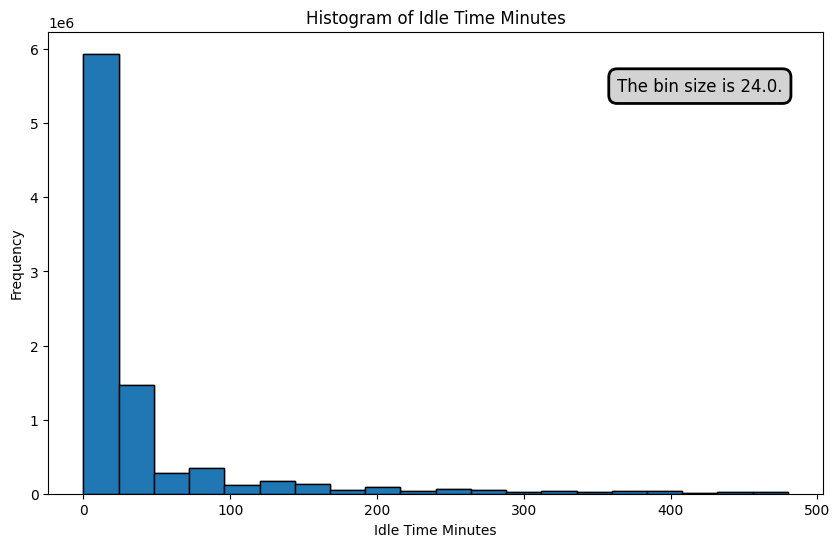

In [7]:
import matplotlib.pyplot as plt

# Assuming df["Idle Time Minutes"] is a numeric column
idle_time_minutes = df["Idle Time Minutes"]

# Set the figure size (width, height) in inches
plt.figure(figsize=(10, 6))

# Plot the histogram and get bin edges
hist, bin_edges, _ = plt.hist(idle_time_minutes, bins=20, edgecolor='black', align='mid')

# Calculate the center positions of each bin
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot the bin intervals
plt.bar(bin_centers, hist, width=(bin_edges[1] - bin_edges[0]), align='center', edgecolor='black')

plt.xlabel("Idle Time Minutes")
plt.ylabel("Frequency")
plt.title("Histogram of Idle Time Minutes")

# Add a border around the note
border_props = dict(boxstyle='round, pad=0.5', fc='lightgray', ec='black', lw=2)

# Add the note with the specified coordinates and border properties
plt.text(420, 5.5e6, f"The bin size is {bin_edges[1] - bin_edges[0]}.", fontsize=12, ha='center', va='center', color='black', bbox=border_props)

plt.show()


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8974520 entries, 0 to 8974519
Data columns (total 48 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   Trip_ID                        object 
 1   Taxi_ID                        object 
 2   Trip_Start_Timestamp           object 
 3   Trip_End_Timestamp             object 
 4   Trip_Seconds                   float64
 5   Trip_Miles                     float64
 6   Pickup_Census_Tract            float64
 7   Dropoff_Census_Tract           float64
 8   Pickup_Community_Area          float64
 9   Dropoff_Community_Area         float64
 10  Fare                           float64
 11  Tips                           float64
 12  Tolls                          float64
 13  Extras                         float64
 14  Payment_Type                   object 
 15  Pickup_Centroid_Latitude       float64
 16  Pickup_Centroid_Longitude      float64
 17  Pickup_Centroid_Location       object 
 18  Dr

Idle Time Minutes

Idle Period

In [9]:
df["Idle Time Minutes"].mean()

38.62667808417609

In [9]:
df["Idle Time Minutes"].describe()


count    8.974520e+06
mean     3.862668e+01
std      7.259773e+01
min      0.000000e+00
25%      0.000000e+00
50%      1.500000e+01
75%      3.000000e+01
max      4.800000e+02
Name: Idle Time Minutes, dtype: float64

In [10]:
df["Idle Period"].describe()

count    8.974520e+06
mean     9.315833e-01
std      2.524596e-01
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: Idle Period, dtype: float64

### Census Tract

In [11]:
#How many rides start per district
grouped = df[["Pickup_Census_Tract", "Idle Time Minutes"]].groupby("Pickup_Census_Tract").sum().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Sum"})
print(grouped.tail())

                            Sum
Pickup_Census_Tract            
1.703108e+10          8709000.0
1.703108e+10         11954370.0
1.703108e+10         14065455.0
1.703132e+10         17268720.0
1.703184e+10         27013425.0


In [12]:
#How many rides end per district
grouped = df[["Dropoff_Census_Tract", "Idle Time Minutes"]].groupby("Dropoff_Census_Tract").sum().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Sum"})
print(grouped.tail())

                             Sum
Dropoff_Census_Tract            
1.703108e+10           9796410.0
1.703108e+10           9903225.0
1.703128e+10          10591500.0
1.703132e+10          14147265.0
1.703184e+10          25400970.0


In [13]:
#How many rides start per district
grouped = df[["Pickup_C->Dropoff_C", "Idle Time Minutes"]].groupby("Pickup_C->Dropoff_C").sum().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Sum"})
print(grouped.tail())

                                      Sum
Pickup_C->Dropoff_C                      
17031839100.0->17031320100.0    1867695.0
17031081500.0->17031839100.0    2142945.0
17031839100.0->17031839100.0    2337555.0
17031320100.0->17031839100.0    2577285.0
nan->nan                      127329195.0


In [14]:
#How many rides start per district
grouped = df[["Pickup_Census_Tract", "Idle Time Minutes"]].groupby("Pickup_Census_Tract").mean().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Average"})
print(grouped.tail())

                     Average
Pickup_Census_Tract         
1.703102e+10           192.0
1.703102e+10           195.0
1.703116e+10           217.5
1.703122e+10           217.5
1.703110e+10           315.0


In [15]:
#How many rides end per district
grouped = df[["Dropoff_Census_Tract", "Idle Time Minutes"]].groupby("Dropoff_Census_Tract").mean().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Average"})
print(grouped.tail())

                         Average
Dropoff_Census_Tract            
1.703125e+10          115.000000
1.703181e+10          119.457831
1.703184e+10          135.000000
1.703130e+10          150.000000
1.703115e+10          165.000000


In [16]:
#How many rides start per district
grouped = df[["Pickup_C->Dropoff_C", "Idle Time Minutes"]].groupby("Pickup_C->Dropoff_C").mean().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Average"})
print(grouped.tail())

                              Average
Pickup_C->Dropoff_C                  
17031020702.0->17031030900.0    480.0
17031040100.0->17031063303.0    480.0
17031160400.0->17031081300.0    480.0
17031051000.0->17031832600.0    480.0
17031010502.0->17031010400.0    480.0


### Varying hexagon diameter

#### Low Resolution

In [17]:
#How many rides start per district
grouped = df[["h3_hex_id_low_res", "Idle Time Minutes"]].groupby("h3_hex_id_low_res").sum().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Sum"})
print(grouped.tail())

                           Sum
h3_hex_id_low_res             
862664ca7ffffff     14819550.0
862664cafffffff     24007185.0
862664d8fffffff     27832035.0
862664c17ffffff     73719375.0
862664c1fffffff    183673350.0


In [18]:
#How many rides end per district
grouped = df[["h3_hex_id_low_res", "Idle Time Minutes"]].groupby("h3_hex_id_low_res").sum().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Sum"})
print(grouped.tail())

                           Sum
h3_hex_id_low_res             
862664ca7ffffff     14819550.0
862664cafffffff     24007185.0
862664d8fffffff     27832035.0
862664c17ffffff     73719375.0
862664c1fffffff    183673350.0


Von Hexagon zu Hexagon auch noch bei anderen möglich

In [19]:
# #How many rides start per district
# grouped = df[["h3_hex_id_low_res->h3_hex_id_low_res", "Idle Time Minutes"]].groupby("h3_hex_id_low_res->h3_hex_id_low_res").sum().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Sum"})
# print(print(grouped.tail())

In [20]:
#How many rides start per district
grouped = df[["h3_hex_id_low_res", "Idle Time Minutes"]].groupby("h3_hex_id_low_res").mean().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Average"})
print(grouped.tail())

                      Average
h3_hex_id_low_res            
862664527ffffff     81.586604
86275936fffffff     83.144279
862664577ffffff     89.000000
862759347ffffff    115.315700
8626641b7ffffff    133.846154


In [21]:
#How many rides end per district
grouped = df[["h3_hex_id_low_res", "Idle Time Minutes"]].groupby("h3_hex_id_low_res").mean().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Average"})
print(grouped.tail())

                      Average
h3_hex_id_low_res            
862664527ffffff     81.586604
86275936fffffff     83.144279
862664577ffffff     89.000000
862759347ffffff    115.315700
8626641b7ffffff    133.846154


In [22]:
# #How many rides start per district
# grouped = df[["Pickup_C->Dropoff_C", "Idle Time Minutes"]].groupby("Pickup_C->Dropoff_C").mean().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Average"})
# print(grouped.tail())

#### Medium Resolution

In [23]:
#How many rides start per district
grouped = df[["h3_hex_id_medium_res", "Idle Time Minutes"]].groupby("h3_hex_id_medium_res").sum().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Sum"})
print(grouped.tail())

                              Sum
h3_hex_id_medium_res             
872664c10ffffff        11881890.0
872664c13ffffff        18741315.0
872664c16ffffff        29891430.0
872664c1affffff        56287260.0
872664c1effffff       118486695.0


In [24]:
#How many rides end per district
grouped = df[["h3_hex_id_medium_res", "Idle Time Minutes"]].groupby("h3_hex_id_medium_res").sum().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Sum"})
print(grouped.tail())

                              Sum
h3_hex_id_medium_res             
872664c10ffffff        11881890.0
872664c13ffffff        18741315.0
872664c16ffffff        29891430.0
872664c1affffff        56287260.0
872664c1effffff       118486695.0


Von Hexagon zu Hexagon auch noch bei anderen möglich

In [25]:
# #How many rides start per district
# grouped = df[["h3_hex_id_medium_res->h3_hex_id_medium_res", "Idle Time Minutes"]].groupby("h3_hex_id_medium_res->h3_hex_id_medium_res").sum().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Sum"})
# print(grouped.tail())

In [26]:
#How many rides start per district
grouped = df[["h3_hex_id_medium_res", "Idle Time Minutes"]].groupby("h3_hex_id_medium_res").mean().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Average"})
print(grouped.tail())

                         Average
h3_hex_id_medium_res            
87275934effffff       108.852660
87275936bffffff       111.111111
872759343ffffff       117.867391
8726641b2ffffff       133.846154
872664d83ffffff       192.000000


In [27]:
#How many rides end per district
grouped = df[["h3_hex_id_medium_res", "Idle Time Minutes"]].groupby("h3_hex_id_medium_res").mean().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Average"})
print(grouped.tail())

                         Average
h3_hex_id_medium_res            
87275934effffff       108.852660
87275936bffffff       111.111111
872759343ffffff       117.867391
8726641b2ffffff       133.846154
872664d83ffffff       192.000000


#### High Resolution

In [28]:
#How many rides start per district
grouped = df[["h3_hex_id_high_res", "Idle Time Minutes"]].groupby("h3_hex_id_high_res").sum().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Sum"})
print(grouped.tail())

                           Sum
h3_hex_id_high_res            
882664c163fffff     23156895.0
882664c1e3fffff     25977720.0
882664c1e1fffff     28434480.0
882664c1edfffff     29571165.0
882664c1a9fffff     37688310.0


In [29]:
#How many rides end per district
grouped = df[["h3_hex_id_high_res", "Idle Time Minutes"]].groupby("h3_hex_id_high_res").sum().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Sum"})
print(grouped.tail())

                           Sum
h3_hex_id_high_res            
882664c163fffff     23156895.0
882664c1e3fffff     25977720.0
882664c1e1fffff     28434480.0
882664c1edfffff     29571165.0
882664c1a9fffff     37688310.0


Von Hexagon zu Hexagon auch noch bei anderen möglich

In [30]:
# #How many rides start per district
# grouped = df[["h3_hex_id_low_res->h3_hex_id_low_res", "Idle Time Minutes"]].groupby("h3_hex_id_low_res->h3_hex_id_low_res").sum().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Sum"})
# print(grouped.tail()) 

In [31]:
#How many rides start per district
grouped = df[["h3_hex_id_high_res", "Idle Time Minutes"]].groupby("h3_hex_id_high_res").mean().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Average"})
print(grouped.tail())

                    Average
h3_hex_id_high_res         
882664d99dfffff       165.0
882664ca39fffff       165.0
882664d83bfffff       192.0
882664d8edfffff       195.0
8827593697fffff       315.0


In [32]:
#How many rides end per district
grouped = df[["h3_hex_id_high_res", "Idle Time Minutes"]].groupby("h3_hex_id_high_res").mean().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Average"})
print(grouped.tail())

                    Average
h3_hex_id_high_res         
882664d99dfffff       165.0
882664ca39fffff       165.0
882664d83bfffff       192.0
882664d8edfffff       195.0
8827593697fffff       315.0


### Diff temporal bin sizes

Hour, Day, Week, Month

#### Hour bin size

In [33]:
# sns.histplot(df["start_time_hourly"])

Rename done
Index(['start_time_hourly', 'Count'], dtype='object')
Len 1 Count
Rename done
Head: 

    Count
0  420592
1  352816
2  289488
3  212715
4  132871
Tail: 

     Count
19  631681
20  599694
21  536343
22  520307
23  488047


,Count
0,420592
1,352816
2,289488
3,212715
4,132871
5,83134
6,88659
7,189859
8,321036
9,384941


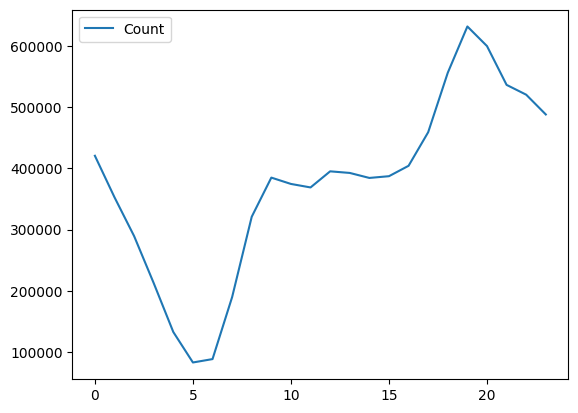

In [34]:
#Wieviele Fahrten pro Stunde?? Irgendwie unnötig
# grouped = df[["start_time_hourly", "Idle Time Minutes"]].groupby(["start_time_hourly"]).count().sort_values(by="Idle Time Minutes").rename(columns={"Trip_Minutes": "Count"})
# print(grouped.tail())
# sns.lineplot(grouped.sort_values(grouped.index.name))


desc.descr_stat(df, columns=["start_time_hourly", "Idle Time Minutes"], group_by=["start_time_hourly"], sort=True, sort_by=["Idle Time Minutes"], as_index=False, agg_mode="count", plot=True)


Rename done
Index(['start_time_hourly', 'Average'], dtype='object')
Len 1 Average
Rename done
Head: 

     Average
0  32.505326
1  31.987240
2  30.239699
3  31.480855
4  37.190508
Tail: 

      Average
19  38.141372
20  37.362005
21  37.041856
22  35.496361
23  34.660986


,Average
0,32.505326
1,31.987240
2,30.239699
3,31.480855
4,37.190508
5,58.410578
6,81.638920
7,60.038397
8,39.856511
9,32.651198


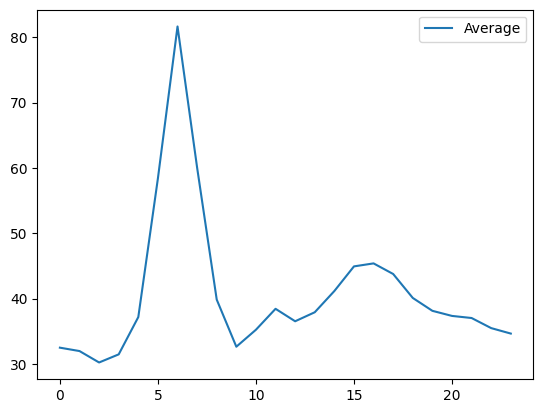

In [35]:
#How many rides start-end combination 
# grouped = df[["start_time_hourly", "Idle Time Minutes"]].groupby(["start_time_hourly"]).mean().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Average"})
# print(grouped.tail())
# sns.lineplot(grouped.sort_values(grouped.index.name))


desc.descr_stat(df, columns=["start_time_hourly", "Idle Time Minutes"], group_by=["start_time_hourly"], sort=True, sort_by=["Idle Time Minutes"], as_index=False, agg_mode="mean", plot=True)


Rename done
Index(['start_time_hourly', 'Sum'], dtype='object')
Len 1 Sum
Rename done
Head: 

          Sum
0  13671480.0
1  11285610.0
2   8754030.0
3   6696450.0
4   4941540.0
Tail: 

           Sum
19  24093180.0
20  22405770.0
21  19867140.0
22  18469005.0
23  16916190.0


,Sum
0,13671480.0
1,11285610.0
2,8754030.0
3,6696450.0
4,4941540.0
5,4855905.0
6,7238025.0
7,11398830.0
8,12795375.0
9,12568785.0


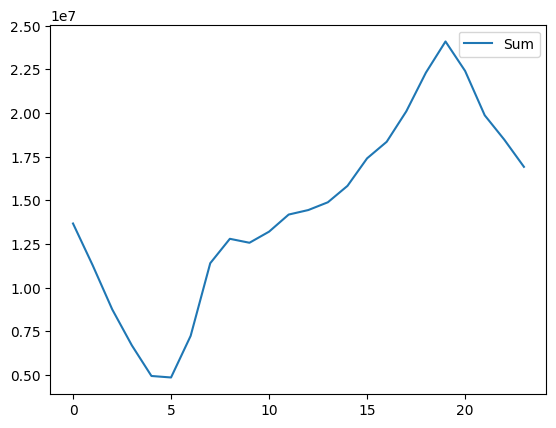

In [36]:
#How many rides start-end combination 
# grouped = df[["start_time_hourly", "Idle Time Minutes"]].groupby(["start_time_hourly"]).sum().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Sum"})
# print(grouped.tail())
# sns.lineplot(grouped.sort_values(grouped.index.name))


desc.descr_stat(df, columns=["start_time_hourly", "Idle Time Minutes"], group_by=["start_time_hourly"], sort=True, sort_by=["Idle Time Minutes"], as_index=False, agg_mode="sum", plot=True)


#### Day Bin size

In [37]:
#How many rides per day
df['Day_Ordered'] = pd.Categorical(df['dayOfWeek'], ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
# sns.histplot(df["Day_Ordered"])
# ax.set_xticks(["Mon", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

Rename done
Index(['Day_Ordered', 'Count'], dtype='object')
Len 1 Count
Rename done
Head: 

     Count
0  1038335
1  1116730
2  1131020
3  1244321
4  1522147
Tail: 

     Count
2  1131020
3  1244321
4  1522147
5  1663204
6  1258763


,Count
0,1038335
1,1116730
2,1131020
3,1244321
4,1522147
5,1663204
6,1258763


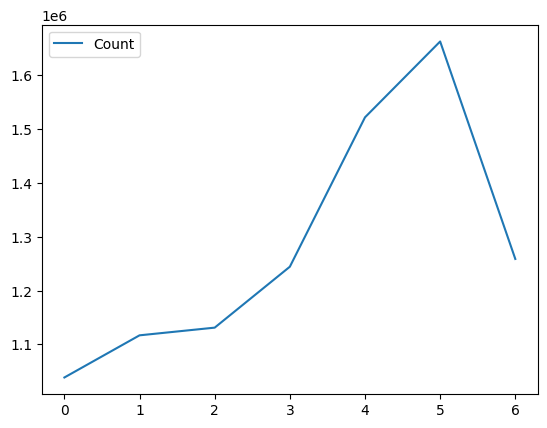

In [38]:
#How many rides start per district
# grouped = df[["Day_Ordered", "Idle Time Minutes"]].groupby(["Day_Ordered"]).count().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Count"})
# print(grouped.tail())
# sns.lineplot(grouped.sort_values(grouped.index.name))


desc.descr_stat(df, columns=["Day_Ordered", "Idle Time Minutes"], group_by=["Day_Ordered"], sort=True, sort_by=["Idle Time Minutes"], as_index=False, agg_mode="count", plot=True)


Rename done
Index(['Day_Ordered', 'Sum'], dtype='object')
Len 1 Sum
Rename done
Head: 

          Sum
0  44165325.0
1  45595125.0
2  47526675.0
3  51194205.0
4  57850485.0
Tail: 

          Sum
2  47526675.0
3  51194205.0
4  57850485.0
5  54728610.0
6  45595470.0


,Sum
0,44165325.0
1,45595125.0
2,47526675.0
3,51194205.0
4,57850485.0
5,54728610.0
6,45595470.0


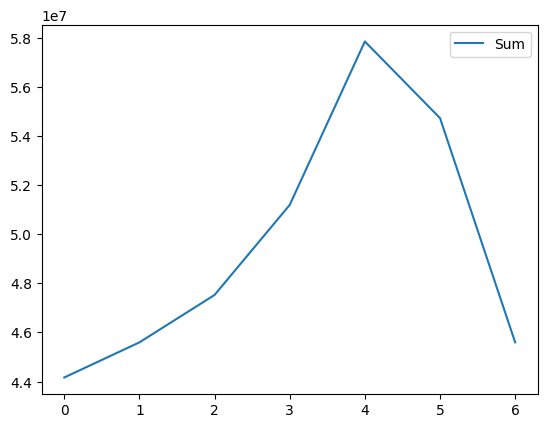

In [39]:
#How many rides start per district
# grouped = df[["Day_Ordered", "Idle Time Minutes"]].groupby(["Day_Ordered"]).sum().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Sum"})
# print(grouped.tail())
# sns.lineplot(grouped.sort_values(grouped.index.name))


desc.descr_stat(df, columns=["Day_Ordered", "Idle Time Minutes"], group_by=["Day_Ordered"], sort=True, sort_by=["Idle Time Minutes"], as_index=False, agg_mode="sum", plot=True)


Rename done
Index(['Day_Ordered', 'Average'], dtype='object')
Len 1 Average
Rename done
Head: 

     Average
0  42.534755
1  40.829140
2  42.021074
3  41.142282
4  38.005846
Tail: 

     Average
2  42.021074
3  41.142282
4  38.005846
5  32.905531
6  36.222442


,Average
0,42.534755
1,40.829140
2,42.021074
3,41.142282
4,38.005846
5,32.905531
6,36.222442


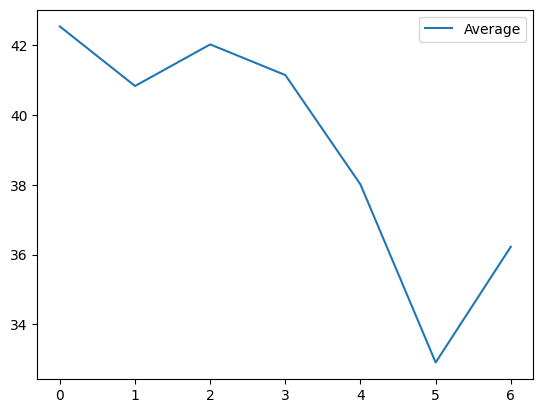

In [40]:
#How many rides start per district
# grouped = df[["Day_Ordered", "Idle Time Minutes"]].groupby(["Day_Ordered"]).mean().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Average"})
# print(grouped.tail())
# sns.lineplot(grouped.sort_values(grouped.index.name))


desc.descr_stat(df, columns=["Day_Ordered", "Idle Time Minutes"], group_by=["Day_Ordered"], sort=True, sort_by=["Idle Time Minutes"], as_index=False, agg_mode="mean", plot=True)


Rename done
Index(['Day_Ordered', 'start_time_hourly', 'Count'], dtype='object')
Len 1 Count
Rename done
Head: 

   Count
0  36528
1  27805
2  20864
3  14713
4  10022
Tail: 

     Count
163  55480
164  50452
165  45371
166  44297
167  42595


,Count
0,36528
1,27805
2,20864
3,14713
4,10022
...,...
163,55480
164,50452
165,45371
166,44297


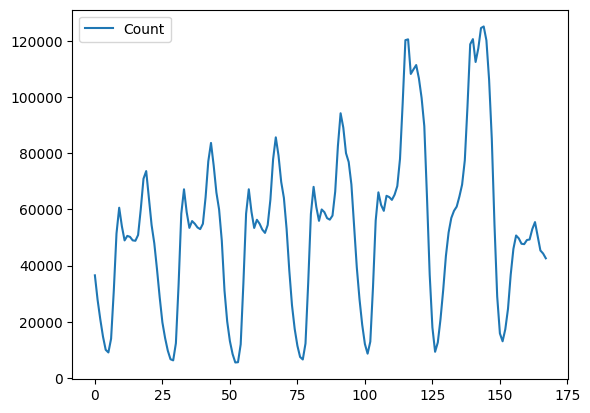

In [41]:
#How many rides start per district
# grouped = df[["Day_Ordered", "start_time_hourly", "Idle Time Minutes"]].groupby(["Day_Ordered", "start_time_hourly"], as_index=False).count().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Count"})
# print(grouped.tail())
# sns.lineplot(grouped.sort_values(by=["Day_Ordered", "start_time_hourly"])[["Day_Ordered","Count"]])


desc.descr_stat(df, columns=["Day_Ordered", "start_time_hourly", "Idle Time Minutes"], group_by=["Day_Ordered", "start_time_hourly"], sort=True, sort_by=["Idle Time Minutes"], as_index=False, agg_mode="count", plot=True)


Rename done
Index(['Day_Ordered', 'start_time_hourly', 'Sum'], dtype='object')
Len 1 Sum
Rename done
Head: 

         Sum
0  1347855.0
1  1020435.0
2   735375.0
3   543435.0
4   493515.0
Tail: 

           Sum
163  2299425.0
164  2148945.0
165  1945905.0
166  1882095.0
167  1871070.0


,Sum
0,1347855.0
1,1020435.0
2,735375.0
3,543435.0
4,493515.0
...,...
163,2299425.0
164,2148945.0
165,1945905.0
166,1882095.0


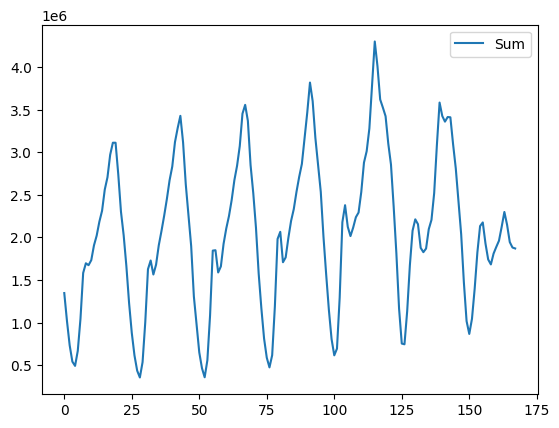

In [42]:
#How many rides start per district
# grouped = df[["Day_Ordered", "start_time_hourly", "Idle Time Minutes"]].groupby(["Day_Ordered", "start_time_hourly"], as_index=False).sum().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Sum"})
# print(grouped.tail())
# sns.lineplot(grouped.sort_values(by=["Day_Ordered", "start_time_hourly"])[["Day_Ordered","Sum"]])


desc.descr_stat(df, columns=["Day_Ordered", "start_time_hourly", "Idle Time Minutes"], group_by=["Day_Ordered", "start_time_hourly"], sort=True, sort_by=["Idle Time Minutes"], as_index=False, agg_mode="sum", plot=True)


Rename done
Index(['Day_Ordered', 'start_time_hourly', 'Average'], dtype='object')
Len 1 Average
Rename done
Head: 

     Average
0  36.899228
1  36.699694
2  35.246118
3  36.935703
4  49.243165
Tail: 

       Average
163  41.446017
164  42.593852
165  42.888740
166  42.488092
167  43.926987


,Average
0,36.899228
1,36.699694
2,35.246118
3,36.935703
4,49.243165
...,...
163,41.446017
164,42.593852
165,42.888740
166,42.488092


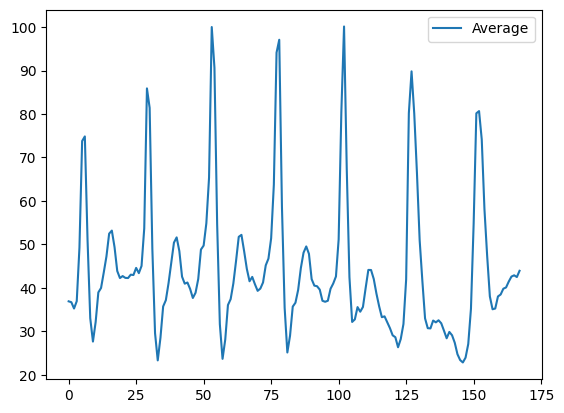

In [43]:
#How many rides start per district
# grouped = df[["Day_Ordered", "start_time_hourly", "Idle Time Minutes"]].groupby(["Day_Ordered", "start_time_hourly"], as_index=False).mean().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Average"})
# print(grouped.tail())
# sns.lineplot(grouped.sort_values(by=["Day_Ordered", "start_time_hourly"])["Average"])

desc.descr_stat(df, columns=["Day_Ordered", "start_time_hourly", "Idle Time Minutes"], group_by=["Day_Ordered", "start_time_hourly"], sort=True, sort_by=["Idle Time Minutes"], as_index=False, agg_mode="mean", plot=True)


Rename done
Index(['start_time_hourly', 'Average'], dtype='object')
Len 1 Average
Rename done
Head: 

     Average
0  32.505326
1  31.987240
2  30.239699
3  31.480855
4  37.190508
Tail: 

      Average
19  38.141372
20  37.362005
21  37.041856
22  35.496361
23  34.660986


,Average
0,32.505326
1,31.987240
2,30.239699
3,31.480855
4,37.190508
5,58.410578
6,81.638920
7,60.038397
8,39.856511
9,32.651198


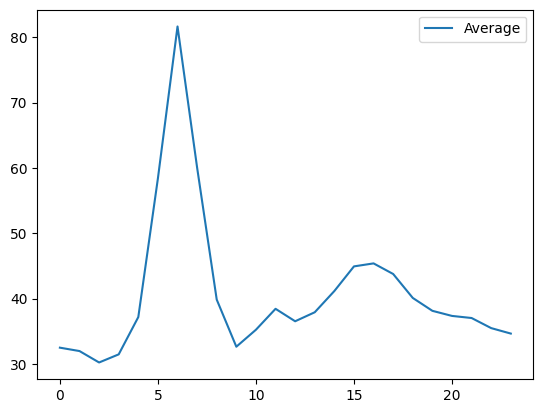

In [44]:
#How many rides start-end combination 
# grouped = df[["start_time_hourly", "Idle Time Minutes"]].groupby(["start_time_hourly"]).mean().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Average"})
# print(grouped.tail())
# sns.lineplot(grouped.sort_values(grouped.index.name))


desc.descr_stat(df, columns=["start_time_hourly", "Idle Time Minutes"], group_by=["start_time_hourly"], sort=True, sort_by=["Idle Time Minutes"], as_index=False, agg_mode="mean", plot=True)


#### Week bin size

<Axes: xlabel='start_time_week', ylabel='Count'>

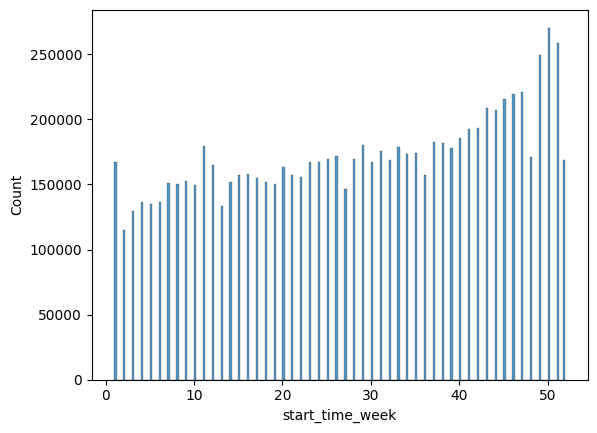

In [45]:
sns.histplot(df["start_time_week"])

Rename done
Index(['Count'], dtype='object')
Len 1 Count
Rename done
Head: 

                  Count
start_time_week        
2                115098
3                129937
13               133380
5                134622
4                136262
Tail: 

                  Count
start_time_week        
46               219786
47               220916
49               249387
51               258418
50               270631


,Count
start_time_week,
2,115098
3,129937
13,133380
5,134622
4,136262
6,136265
27,146486
10,149907
19,150016


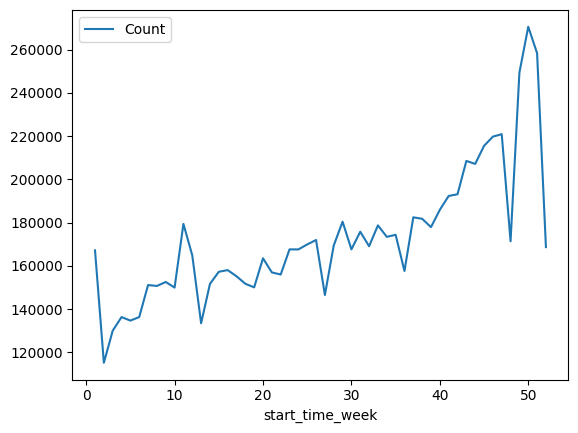

In [46]:
#How many rides start per district
#maybe filter not zeros out?! 
# grouped = df[["start_time_week", "Idle Time Minutes"]].groupby(["start_time_week"]).count().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Count"})
# print(grouped.tail())
# sns.lineplot(grouped.sort_values(grouped.index.name))

desc.descr_stat(df, columns=["start_time_week", "Idle Time Minutes"], group_by=["start_time_week"], sort=True, sort_by=["start_time_week"], agg_mode="count", plot=True)


Rename done
Index(['Sum'], dtype='object')
Len 1 Sum
Rename done
Head: 

                       Sum
start_time_week           
2                4543860.0
3                4999815.0
4                5108670.0
5                5119830.0
6                5148285.0
Tail: 

                       Sum
start_time_week           
46               8387940.0
47               8601990.0
50               8759790.0
51               8941725.0
49               8960160.0


,Sum
start_time_week,
2,4543860.0
3,4999815.0
4,5108670.0
5,5119830.0
6,5148285.0
13,5341065.0
8,5478765.0
7,5500815.0
9,5629920.0


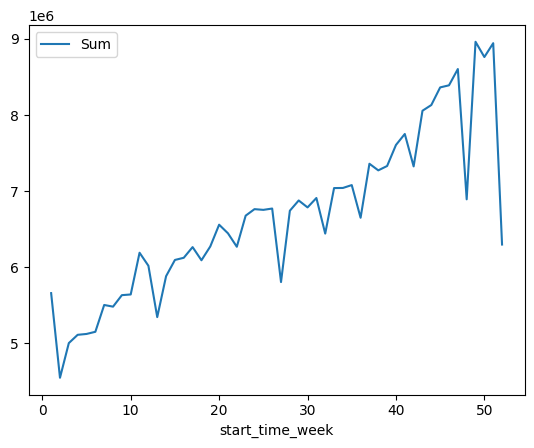

In [47]:
#How many rides start per district
# grouped = df[["start_time_week", "Idle Time Minutes"]].groupby(["start_time_week"]).sum().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Sum"})
# print(grouped.tail())
# sns.lineplot(grouped.sort_values(grouped.index.name))


desc.descr_stat(df, columns=["start_time_week", "Idle Time Minutes"], group_by=["start_time_week"], sort=True, sort_by=["start_time_week"], agg_mode="sum", plot=True)


Rename done
Index(['Average'], dtype='object')
Len 1 Average
Rename done
Head: 

                   Average
start_time_week           
50               32.368021
1                33.840615
11               34.491362
51               34.601789
49               35.928737
Tail: 

                   Average
start_time_week           
40               40.900780
21               41.054322
39               41.189985
19               41.796242
36               42.180397


,Average
start_time_week,
50,32.368021
1,33.840615
11,34.491362
51,34.601789
49,35.928737
8,36.364369
7,36.409948
12,36.503810
9,36.917266


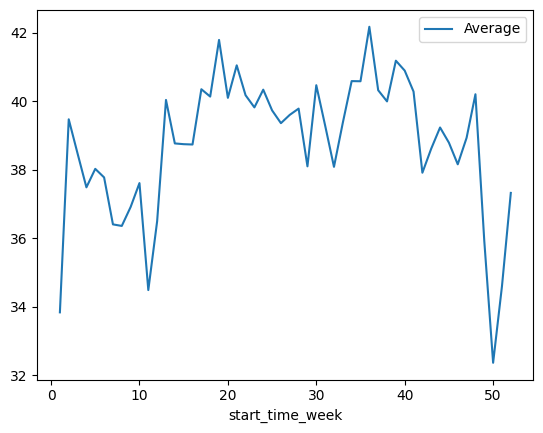

In [48]:
#How many rides start per district
# grouped = df[["start_time_week", "Idle Time Minutes"]].groupby(["start_time_week"]).mean().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Average"})
# print(grouped.tail())
# sns.lineplot(grouped.sort_values(grouped.index.name))


desc.descr_stat(df, columns=["start_time_week", "Idle Time Minutes"], group_by=["start_time_week"], sort=True, sort_by=["start_time_week"], agg_mode="mean", plot=True)


Rename done
Index(['start_time_week', 'start_time_hourly', 'Count'], dtype='object')
Len >1
Rename done
Head: 

   Count
0   7070
1   7283
2   6959
3   5579
4   3649
Tail: 

      Count
1243  11508
1244  11293
1245  10141
1246   9457
1247   8965


,Count
0,7070
1,7283
2,6959
3,5579
4,3649
...,...
1243,11508
1244,11293
1245,10141
1246,9457


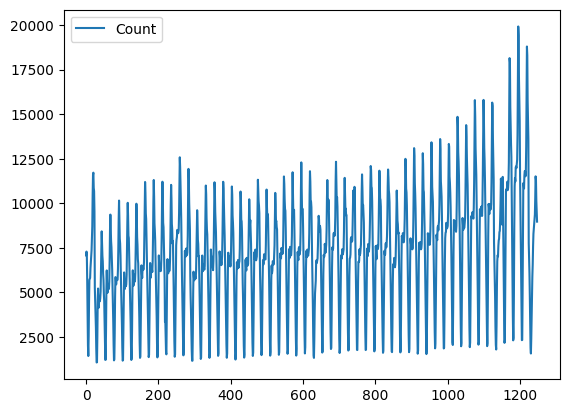

In [49]:
#How many rides start per district
# grouped = df[["start_time_week", "start_time_hourly", "Idle Time Minutes"]].groupby(["start_time_week", "start_time_hourly"], as_index=False).count().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Count"})
# print(grouped.tail())
# sns.lineplot(grouped.sort_values(by=["start_time_week", "start_time_hourly"])[["Count"]])


desc.descr_stat(df, columns=["start_time_week", "start_time_hourly", "Idle Time Minutes"], group_by=["start_time_week", "start_time_hourly"], sort=True, sort_by=["start_time_week", "start_time_hourly"], as_index=False, agg_mode="count", plot=True)


Rename done
Index(['start_time_week', 'start_time_hourly', 'Sum'], dtype='object')
Len >1
Rename done
Head: 

        Sum
0  207900.0
1  191085.0
2  172215.0
3  139035.0
4  104520.0
Tail: 

           Sum
1243  424365.0
1244  414165.0
1245  381675.0
1246  359700.0
1247  332895.0


,Sum
0,207900.0
1,191085.0
2,172215.0
3,139035.0
4,104520.0
...,...
1243,424365.0
1244,414165.0
1245,381675.0
1246,359700.0


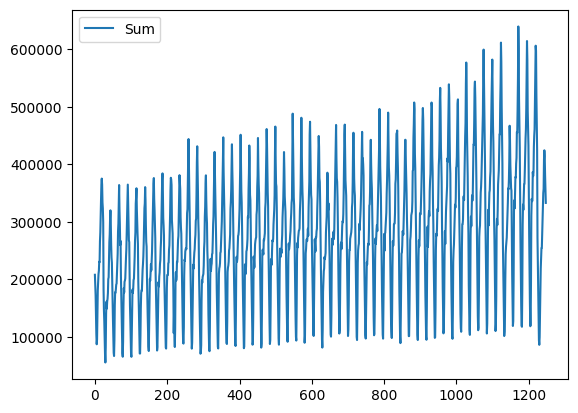

In [50]:
#How many rides start per district
# grouped = df[["start_time_week", "start_time_hourly", "Idle Time Minutes"]].groupby(["start_time_week", "start_time_hourly"], as_index=False).sum().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Sum"})
# print(grouped.tail())
# sns.lineplot(grouped.sort_values(by=["start_time_week", "start_time_hourly"])[["Sum"]])

desc.descr_stat(df, columns=["start_time_week", "start_time_hourly", "Idle Time Minutes"], group_by=["start_time_week", "start_time_hourly"], sort=True, sort_by=["start_time_week", "start_time_hourly"], as_index=False, agg_mode="sum", plot=True)


Rename done
Index(['start_time_week', 'start_time_hourly', 'Average'], dtype='object')
Len 1 Average
Rename done
Head: 

     Average
0  29.405941
1  26.237128
2  24.747090
3  24.921133
4  28.643464
Tail: 

        Average
1243  36.875652
1244  36.674489
1245  37.636821
1246  38.035318
1247  37.132738


,Average
0,29.405941
1,26.237128
2,24.747090
3,24.921133
4,28.643464
...,...
1243,36.875652
1244,36.674489
1245,37.636821
1246,38.035318


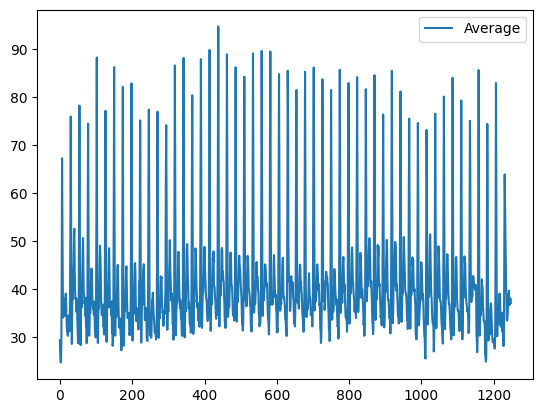

In [51]:
#How many rides start per district
# grouped = df[["start_time_week", "start_time_hourly", "Idle Time Minutes"]].groupby(["start_time_week", "start_time_hourly"], as_index=False).mean().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Average"})
# print(grouped.tail())
# sns.lineplot(grouped.sort_values(by=["start_time_week", "start_time_hourly"])[["Average"]])


desc.descr_stat(df, columns=["start_time_week", "start_time_hourly", "Idle Time Minutes"], group_by=["start_time_week", "start_time_hourly"], sort=True, sort_by=["Idle Time Minutes"], as_index=False, agg_mode="mean", plot=True)


#### Month bin size

<Axes: xlabel='start_time_month', ylabel='Count'>

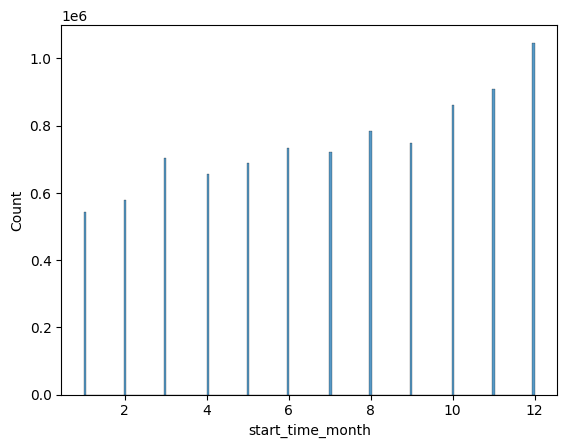

In [52]:
sns.histplot(df["start_time_month"])

Rename done
Index(['start_time_month', 'Count'], dtype='object')
Len 1 Count
Rename done
Head: 

    Count
0  542417
1  579133
2  704599
3  655631
4  687903
Tail: 

      Count
7    782930
8    749200
9    860663
10   908771
11  1046948


,Count
0,542417
1,579133
2,704599
3,655631
4,687903
5,733477
6,722848
7,782930
8,749200
9,860663


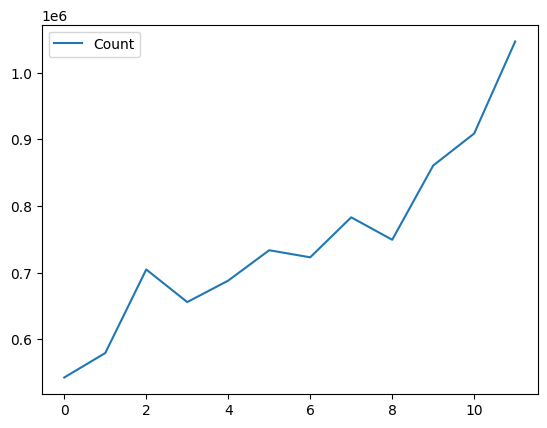

In [53]:
#How many rides start per district
# grouped = df[["start_time_month", "Idle Time Minutes"]].groupby(["start_time_month"]).count().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Count"})
# print(grouped.tail())
# sns.lineplot(grouped.sort_values(grouped.index.name))


desc.descr_stat(df, columns=["start_time_month", "Idle Time Minutes"], group_by=["start_time_month"], sort=True, sort_by=["Idle Time Minutes"], as_index=False, agg_mode="count", plot=True)


Rename done
Index(['start_time_month', 'Sum'], dtype='object')
Len 1 Sum
Rename done
Head: 

          Sum
0  20867505.0
1  21409425.0
2  25810650.0
3  25879710.0
4  28149210.0
Tail: 

           Sum
7   30920970.0
8   30467415.0
9   34147860.0
10  34966080.0
11  36309315.0


,Sum
0,20867505.0
1,21409425.0
2,25810650.0
3,25879710.0
4,28149210.0
5,28903125.0
6,28824630.0
7,30920970.0
8,30467415.0
9,34147860.0


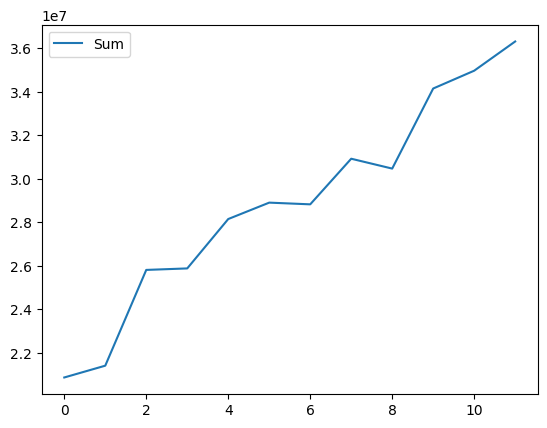

In [54]:
#How many rides start per district
# grouped = df[["start_time_month", "Idle Time Minutes"]].groupby(["start_time_month"]).sum().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Sum"})
# print(grouped.tail())
# sns.lineplot(grouped.sort_values(grouped.index.name))


desc.descr_stat(df, columns=["start_time_month", "Idle Time Minutes"], group_by=["start_time_month"], sort=True, sort_by=["Idle Time Minutes"], as_index=False, agg_mode="sum", plot=True)


Rename done
Index(['start_time_month', 'Average'], dtype='object')
Len 1 Average
Rename done
Head: 

     Average
0  38.471333
1  36.968063
2  36.631687
3  39.472981
4  40.920319
Tail: 

      Average
7   39.493914
8   40.666598
9   39.676226
10  38.476228
11  34.681106


,Average
0,38.471333
1,36.968063
2,36.631687
3,39.472981
4,40.920319
5,39.405632
6,39.876475
7,39.493914
8,40.666598
9,39.676226


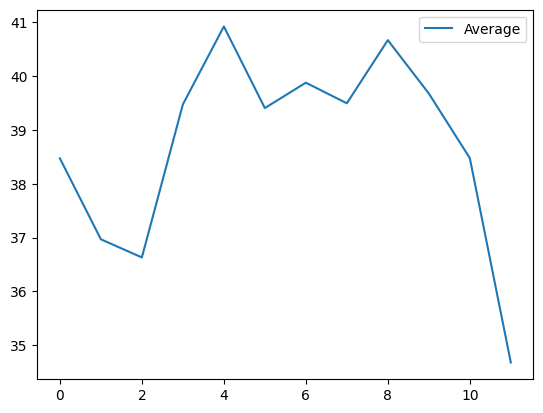

In [55]:
#How many rides start per district
# grouped = df[["start_time_month", "Idle Time Minutes"]].groupby(["start_time_month"]).mean().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Average"})
# print(grouped.tail()) 
# sns.lineplot(grouped.sort_values(grouped.index.name))


desc.descr_stat(df, columns=["start_time_month", "Idle Time Minutes"], group_by=["start_time_month"], sort=True, sort_by=["Idle Time Minutes"], as_index=False, agg_mode="mean", plot=True)


Rename done
Index(['start_time_month', 'start_time_hourly', 'Count'], dtype='object')
Len 1 Count
Rename done
Head: 

   Count
0  23718
1  21539
2  19488
3  14824
4   9318
Tail: 

     Count
283  75544
284  74450
285  65557
286  61243
287  56788


,Count
0,23718
1,21539
2,19488
3,14824
4,9318
...,...
283,75544
284,74450
285,65557
286,61243


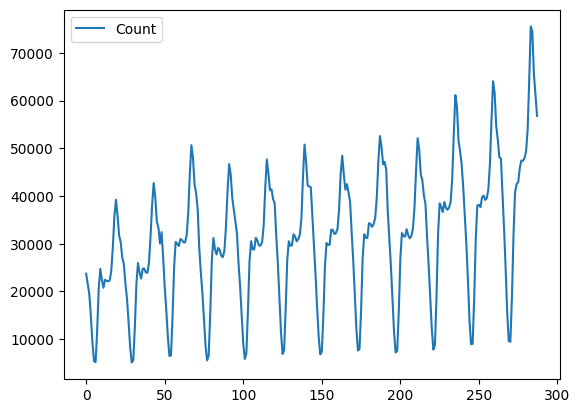

In [56]:
#How many rides start per district
# grouped = df[["start_time_month", "start_time_hourly", "Idle Time Minutes"]].groupby(["start_time_month", "start_time_hourly"], as_index=False).count().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Count"})
# print(grouped.tail())
# sns.lineplot(grouped.sort_values(by=["start_time_month", "start_time_hourly"])[["Count"]])


desc.descr_stat(df, columns=["start_time_month", "start_time_hourly", "Idle Time Minutes"], group_by=["start_time_month", "start_time_hourly"], sort=True, sort_by=["Idle Time Minutes"], as_index=False, agg_mode="count", plot=True)


Rename done
Index(['start_time_month', 'start_time_hourly', 'Sum'], dtype='object')
Len 1 Sum
Rename done
Head: 

        Sum
0  782205.0
1  656175.0
2  553800.0
3  430545.0
4  314505.0
Tail: 

           Sum
283  2501430.0
284  2398410.0
285  2094870.0
286  1958505.0
287  1797045.0


,Sum
0,782205.0
1,656175.0
2,553800.0
3,430545.0
4,314505.0
...,...
283,2501430.0
284,2398410.0
285,2094870.0
286,1958505.0


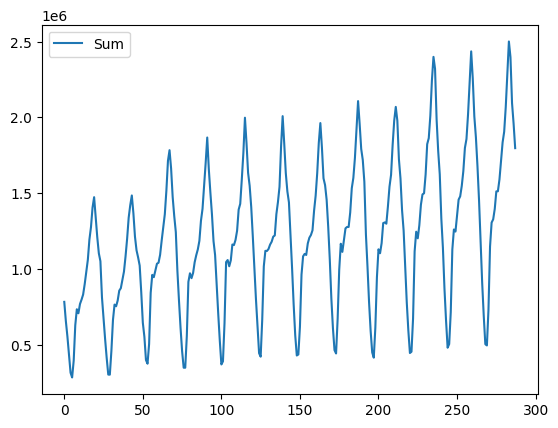

In [57]:
#How many rides start per district
# grouped = df[["start_time_month", "start_time_hourly", "Idle Time Minutes"]].groupby(["start_time_month", "start_time_hourly"], as_index=False).sum().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Sum"})
# print(grouped.tail())
# sns.lineplot(grouped.sort_values(by=["start_time_month", "start_time_hourly"])[["Sum"]])


desc.descr_stat(df, columns=["start_time_month", "start_time_hourly", "Idle Time Minutes"], group_by=["start_time_month", "start_time_hourly"], sort=True, sort_by=["Idle Time Minutes"], as_index=False, agg_mode="sum", plot=True)


Rename done
Index(['start_time_month', 'start_time_hourly', 'Average'], dtype='object')
Len 1 Average
Rename done
Head: 

     Average
0  32.979383
1  30.464506
2  28.417488
3  29.043780
4  33.752415
Tail: 

       Average
283  33.112226
284  32.215044
285  31.954940
286  31.979247
287  31.644802


,Average
0,32.979383
1,30.464506
2,28.417488
3,29.043780
4,33.752415
...,...
283,33.112226
284,32.215044
285,31.954940
286,31.979247


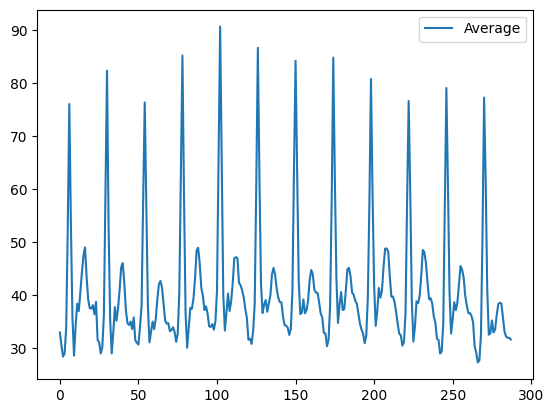

In [58]:
#How many rides start per district
# grouped = df[["start_time_month", "start_time_hourly", "Idle Time Minutes"]].groupby(["start_time_month", "start_time_hourly"], as_index=False).mean().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Average"})
# print(grouped.tail()) 
# sns.lineplot(grouped.sort_values(by=["start_time_month", "start_time_hourly"])[["Average"]])


desc.descr_stat(df, columns=["start_time_month", "start_time_hourly", "Idle Time Minutes"], group_by=["start_time_month", "start_time_hourly"], sort=True, sort_by=["Idle Time Minutes"], as_index=False, agg_mode="mean", plot=True)
